# 1. Title and Executive Summary


### Sleep Health and Lifestyle Data Analysis

This project focuses on an analysis of the Sleep Health and Lifestyle dataset, summarized in the data card section below.  Key focuses of the analysis are which demographic and health factors most influence sleep.  This notebook contains:
- **Data card** summarizing the dataset origin, fields, units, limitations, and license
- **Loading and File IO** section detailing how the dataset was imported
- **Exploratory data analysis** of the dataset, including [] visualizations 
- **Conclusions**, summarizing my findings based on the EDA
- **Appendix**, resources and references 

# 2. Data Card

### Dataset Overview

- **Dataset Origin**: Kaggle 
- **Dataset Link**: https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset
- **Fields**: 
  - Person ID: An identifier for each individual.
  - Gender: The gender of the person (Male/Female).
  - Age: Age of individual in years. 
  - Occupation: Profession of the individual. 
  - Sleep Duration: Duration of sleep in hours
  - Quality of Sleep: Subjective rating of sleep on a scale of 1-10
  - Physical Activity Level: Minutes of physical activity per day
  - Stress Level: Subjective rating of stress level on a scale of 1-10
  - BMI Category: The BMI category of the person (Underweight, Normal, Overweight).
  - Blood Pressure: blood pressure measurement of the person, (systolic/diastolic). 
  - Heart Rate: The resting heart rate in beats per minute.
  - Daily Steps: Number of steps taken per day. 
  - Sleep Disorder: The presence or absence of a sleep disorder in the person (None, Insomnia, Sleep Apnea).
- **Units**: 
- **Limitations**: This is a synthetic dataset created for educational purposes, so the data may contain logical or technical errors. 
- **License**: Public Domain


# 3. Loading and File IO

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
# Data Loading
pd.set_option('display.max_columns', None)
sleepy_path = 'data/SleepyData.csv'
try:
  SleepyData = pd.read_csv(sleepy_path)
except FileNotFoundError:
  print(f"Error: {sleepy_path} not found. Check data / folder and file name")

except pd.errors.ParserError:
  print(
      f"Error: Parsing failed for {sleepy_path}. check delimiter or bad rows.")
else:
  print("Sleepy data loaded successfully!")
  print(SleepyData.info())

Sleepy data loaded successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage

### Data Cleaning and Optimization

1. Currently, sleep quality and stress levels are rated 1-10. I'm converting them to categorical (low, moderate, high) in order to group by these categories in later steps. 

In [54]:
# Data Cleaning and Optimization

# Converting sleep quality and stress level to categorical data types (low, moderate, high).
# Currently, they are measured on a scale of 1-10.
# Using if/elif to map the numerical values to categorical labels.

# Checking the min and max values of each category before converting to categorical

print("\nBefore converting Sleep Quality and Stress Level to categorical:")
print("Quality of Sleep raw min/max:",
      SleepyData["Quality of Sleep"].min(), SleepyData["Quality of Sleep"].max())
print("Stress Level raw min/max:",
      SleepyData["Stress Level"].min(), SleepyData["Stress Level"].max())

# Converting to int to ensure the categorize levels function will work
SleepyData["Quality of Sleep"] = pd.to_numeric(
    SleepyData["Quality of Sleep"], errors="coerce")
SleepyData["Stress Level"] = pd.to_numeric(
    SleepyData["Stress Level"], errors="coerce")

# Categorizing into low (<=3), moderate (4-7), and high (>=8)


def categorize_levels(value: int) -> str:
  if value <= 3:
    return 'low'
  elif 4 <= value <= 7:
    return 'moderate'
  else:
    return 'high'


# Applying the categorization
SleepyData["Quality of Sleep"] = SleepyData["Quality of Sleep"].apply(
    categorize_levels).astype("category")
SleepyData["Stress Level"] = SleepyData["Stress Level"].apply(
    categorize_levels).astype("category")

# Printing the results
# they match the min and max values (Nobody rated quality of sleep less than 3, so there are no low values)
print("\nAfter converting Sleep Quality and Stress Level to categorical:")
print(SleepyData["Quality of Sleep"].unique())
print(SleepyData["Stress Level"].unique())


Before converting Sleep Quality and Stress Level to categorical:
Quality of Sleep raw min/max: 4 9
Stress Level raw min/max: 3 8

After converting Sleep Quality and Stress Level to categorical:
['moderate', 'high']
Categories (2, object): ['high', 'moderate']
['moderate', 'high', 'low']
Categories (3, object): ['high', 'low', 'moderate']


2. I am adding an age groups column to the data set in order to group by age more efficiently. 
- Grouping ages into young adult (<35), adult (<50), and middle aged (>50). Ages range from 27-59.
- Using merge with SleepyData to add the age groups column

In [ ]:
# Grouping ages into young adult (<35), adult (<50), and middle aged (>50). Ages range from 27-59.

age_groups = pd.DataFrame({
    'Age': SleepyData['Age'],
    'Age Group': pd.cut(SleepyData['Age'], bins=[26, 34, 49, 60],
                        labels=['young adult', 'adult', 'middle aged'])
})
# Using merge with SleepyData to add the age groups column
SleepyData_merged = SleepyData.merge(age_groups, on="Age", how="left")

# Test of merge: print(SleepyData_merged[["Person ID","Age","Age Group","Sleep Duration"]].head())

3. Prepping Raw Data for Visualizations
<br>
This code block contains several functions to prepare my raw data for visualizations. 
- Dict mapping for BMI category
- Dict mapping for sleep disorder
- Eliminating duplicate values in the occupation column with set
- Pivot table for visualization: average Sleep Duration by Occupation and Stress Level
- Grouping by gender and calculating sleep duration (touple)
- Grouping by stress level and calculate sleep duration
- Grouping by age groups and calculate sleep duration

In [ ]:
# Preparing data for visualization

# Dict mapping for BMI Category
bmi_map = {"Underweight": 0, "Normal": 1, "Overweight": 2}
SleepyData["BMI_Code"] = SleepyData["BMI Category"].map(bmi_map)

# Dict mapping for Sleep Disorder
disorder_map = {"None": 0, "Insomnia": 1, "Sleep Apnea": 2}
SleepyData["SleepDisorder_Code"] = SleepyData["Sleep Disorder"].map(
    disorder_map)

# Emilinating duplicate occupations
unique_occupations = set(SleepyData["Occupation"])
# test of unique occupations: print("Unique Occupations:", unique_occupations)

# Pivot table for visualization: average Sleep Duration by Occupation and Stress Level
occupation_metrics_pivot = SleepyData.pivot_table(
    index="Occupation",
    columns="Stress Level",
    values="Sleep Duration",
    aggfunc="mean"
)
# Test of pivot: print(occupation_metrics_pivot)

# Group by gender and calculate sleep duration (touple)
gender_sleep_stats = SleepyData.groupby("Gender").agg({
    "Sleep Duration": ("mean", "std")
}).reset_index()

# group by stress level and calculate sleep duration
stress_sleep_duration = SleepyData.groupby("Stress Level").agg({
    "Sleep Duration": "mean",
}).reset_index()

# Group by age groups and calculate sleep duration
agegroup_sleep_duration = SleepyData_merged.groupby("Age Group").agg({
    "Sleep Duration": "mean",
}).reset_index()

  Stress Level  Sleep Duration
0         high        6.050000
1          low        8.226761
2     moderate        7.123605


C:\Users\eghea\AppData\Local\Temp\ipykernel_15144\3904265997.py:16: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  occupation_metrics_pivot = SleepyData.pivot_table(
C:\Users\eghea\AppData\Local\Temp\ipykernel_15144\3904265997.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stress_sleep_duration = SleepyData.groupby("Stress Level").agg({


# Exploratory Data Analysis (EDA)

### Statistical Insights

1. Distribution characterization of a key outcome. center, spread, skew, and outliers. include a figure and a tidy summary table.
- Naturally, I chose sleep duration, seen below. 


Sleep Duration Statistics DataFrame:
                       Value
Mean                7.132086
Median              7.200000
Mode                7.200000
Standard Deviation  0.795657
Variance            0.633070
Skewness            0.037554
Kurtosis           -1.286506
Min                 5.800000
Max                 8.500000


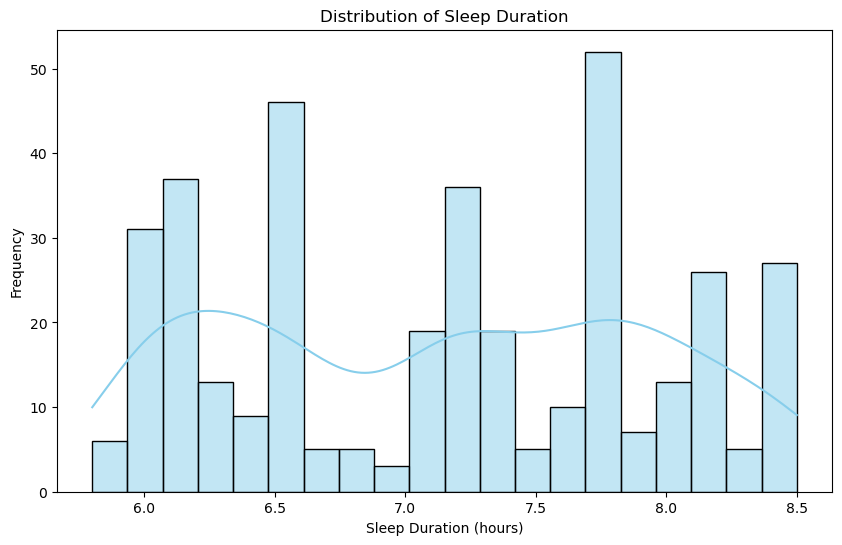

In [ ]:
# Statistical Insight 1: Distribution of sleep duration.
# summary table of: center, spread, skew, and outliers.
sleep_duration_stats = {
    "Mean": SleepyData["Sleep Duration"].mean(),
    "Median": SleepyData["Sleep Duration"].median(),
    "Mode": SleepyData["Sleep Duration"].mode()[0],
    "Standard Deviation": SleepyData["Sleep Duration"].std(),
    "Variance": SleepyData["Sleep Duration"].var(),
    "Skewness": SleepyData["Sleep Duration"].skew(),
    "Kurtosis": SleepyData["Sleep Duration"].kurtosis(),
    "Min": SleepyData["Sleep Duration"].min(),
    "Max": SleepyData["Sleep Duration"].max()
}
# Creating dataframe with the sleep duration stats:
sleep_duration_stats_df = pd.DataFrame.from_dict(
    sleep_duration_stats, orient='index', columns=['Value']
)
print("\nSleep Duration Statistics DataFrame:")
print(sleep_duration_stats_df)

# Figure: Histogram of Sleep Duration stats
plt.figure(figsize=(10, 6))
sns.histplot(SleepyData["Sleep Duration"], bins=20, kde=True, color='skyblue')
plt.title("Distribution of Sleep Duration")
plt.xlabel("Sleep Duration (hours)")
plt.ylabel("Frequency")
plt.show()

### Statistical Insight 2: Group compaison of gender on sleep duration.
Instructions: Group comparison on a numeric variable. independent t test or Welch or nonparametric alternative. report effect size and 95 percent CI.

Sources used for this insight:
- https://www.geeksforgeeks.org/machine-learning/welchs-t-test-in-python/
- https://www.datanovia.com/en/lessons/t-test-effect-size-using-cohens-d-measure/
- https://machinelearningmastery.com/effect-size-measures-in-python/
- https://datagy.io/python-confidence-intervals/


In [ ]:
# Statistical Insight 2: Group compaison of gender on sleep duration.
# Group comparison on a numeric variable. independent t test or Welch or nonparametric alternative. report effect size and 95 percent CI.
# Created earlier: Group by gender and calculate sleep duration (touple)
import scipy.stats as stats
gender_sleep_stats = SleepyData.groupby("Gender").agg({
    "Sleep Duration": ("mean", "std")
}).reset_index()
# t-test:
male_sleep = SleepyData[SleepyData["Gender"] == "Male"]["Sleep Duration"]
female_sleep = SleepyData[SleepyData["Gender"] == "Female"]["Sleep Duration"]
t_stat, p_value = stats.ttest_ind(male_sleep, female_sleep, equal_var=False)
# effect size (Cohen's d)
mean_diff = male_sleep.mean() - female_sleep.mean()
pooled_sd = np.sqrt(((male_sleep.std(ddof=1)**2) +
                    (female_sleep.std(ddof=1)**2)) / 2)
cohens_d = mean_diff / pooled_sd

# 95% CI for the difference in means
se_diff = np.sqrt(male_sleep.var(ddof=1)/len(male_sleep) +
                  female_sleep.var(ddof=1)/len(female_sleep))
df_num = (male_sleep.var(ddof=1)/len(male_sleep) +
          female_sleep.var(ddof=1)/len(female_sleep))**2
df_den = ((male_sleep.var(ddof=1)/len(male_sleep))**2/(len(male_sleep)-1) +
          (female_sleep.var(ddof=1)/len(female_sleep))**2/(len(female_sleep)-1))
df = df_num/df_den
ci_range = stats.t.ppf(0.975, df) * se_diff
ci_low, ci_high = mean_diff - ci_range, mean_diff + ci_range
# Printing t-test results
print("\nGroup Comparison: Sleep Duration by Gender")
print(gender_sleep_stats)
print(f"\nWelch's t-test: t = {t_stat:.3f}, p = {p_value:.3f}")
print(f"Mean difference = {mean_diff:.2f} hrs")
print(f"Cohen's d = {cohens_d:.2f}")
print(f"95% CI for mean difference = [{ci_low:.2f}, {ci_high:.2f}]")


Group Comparison: Sleep Duration by Gender
   Gender Sleep Duration          
                    mean       std
0  Female       7.229730  0.879434
1    Male       7.036508  0.693197

Welch's t-test: t = -2.357, p = 0.019
Mean difference = -0.19 hrs
Cohen's d = -0.24
95% CI for mean difference = [-0.35, -0.03]


### Statistical Insight 3: 
Instructions: Association between two categorical variables. chi square or Fisher when appropriate. include a proportion plot with CIs.



Association between Sleep Quality and Stress Level
Contingency Table:
Stress Level      high  low  moderate
Quality of Sleep                     
high                 0   71       109
moderate            70    0       124

Chi-square test: chi2 = 141.640, p = 0.000, dof = 2


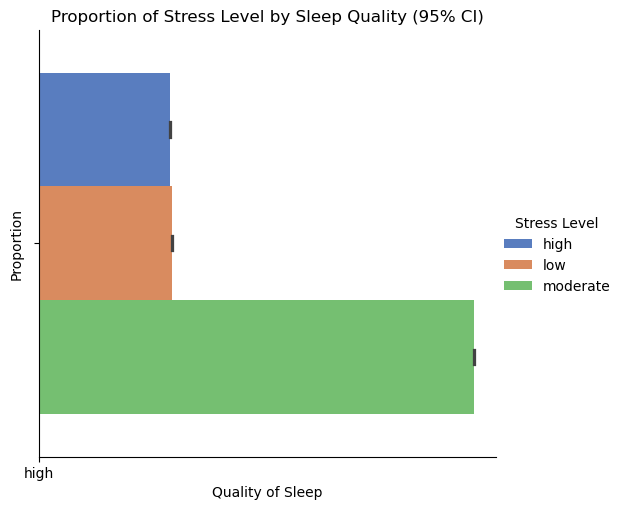

In [57]:
# Statistical Insight 3: Association between two categorical variables. chi square or Fisher when appropriate.
# include a proportion plot with CIs.

# association between Sleep Quality and Stress Level

import scipy.stats as stats
import seaborn as sns

contingency_table = pd.crosstab(
    SleepyData["Quality of Sleep"], SleepyData["Stress Level"])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
# Printing chi-square test results
print("\nAssociation between Sleep Quality and Stress Level")
print("Contingency Table:")
print(contingency_table)
print(f"\nChi-square test: chi2 = {chi2:.3f}, p = {p:.3f}, dof = {dof}")
# Proportion plot with CIs
sns.catplot(
    data=SleepyData, kind="bar",
    x="Quality of Sleep", y=None, hue="Stress Level",
    estimator=lambda x: len(x) / len(SleepyData),
      errorbar=('ci', 95), capsize=0.1, palette="muted"
)
plt.title("Proportion of Stress Level by Sleep Quality (95% CI)")
plt.ylabel("Proportion")
plt.show()

In [ ]:
# Draft of potential multi-panel visualization - sleep duration distribution by occupation

# import seaborn as sns
# import matplotlib.pyplot as plt

# occupation_grid = sns.FacetGrid(SleepyData, col="Occupation", col_wrap=3, height=3, sharey=False)
# occupation_grid.map(sns.histplot, "Sleep Duration", kde=True)

# occupation_grid.set_titles("{col_name}")

# for ax in occupation_grid.axes.flatten():
#     ax.set_xlabel("Sleep Duration (hours)")
#     ax.tick_params(axis='x', which='both', labelbottom=True)

# plt.subplots_adjust(top=0.9)
# g.figure.suptitle("Distribution of Sleep Duration by Occupation", fontsize=14)
# plt.show()